# **Estudo da área**
a
>a.

a:
1.   a
2.   a


Script desensolvido para o projeto de tese que visa analisar a metodologia de `lightningjump` no estado do ceará com dados de pluviometros da Funceme e dados de relâmpagos do GLM

Autor: Samuel Amorim Silva (2024)


In [1]:
import numpy as np

# Definir a latitude, longitude e raio do ponto
latitude = -5.106  # Latitude do ponto
longitude = -38.3737  # Longitude do ponto
raio = 100  # Raio em km
earth_radius_km = 6371  # Raio da Terra em km
cidade = "Morada Nova"

# Calcular os limites da área
delta_lat = raio / (earth_radius_km * np.pi / 180)
delta_lon = raio / (earth_radius_km * np.cos(np.radians(latitude)) * np.pi / 180)

latmin = latitude - delta_lat
latmax = latitude + delta_lat
lonmin = longitude - delta_lon
lonmax = longitude + delta_lon

# Limites do Brasil (opcional, se você precisar)
# lonmin, lonmax, latmin, latmax = -41.5, -37.0, -7.0, -2.5
extent = [lonmin, latmin, lonmax, latmax]

print("Limites da área:")
print(f"Latitude Min: {latmin}, Latitude Max: {latmax}")
print(f"Longitude Min: {lonmin}, Longitude Max: {lonmax}")


Limites da área:
Latitude Min: -6.005321605918731, Latitude Max: -4.206678394081269
Longitude Min: -39.27660455605617, Longitude Max: -37.47079544394383


In [2]:
!apt-get install -qq libproj-dev proj-data proj-bin libgeos-dev
!pip install -qq cartopy matplotlib geopandas

Selecting previously unselected package proj-bin.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.1.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.1.1-1~jammy0) ...
Setting up proj-bin (9.1.1-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.8 MB/s eta 0:00:00


In [3]:
from matplotlib.patches import Circle

In [4]:
# Importando as bibliotecas
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import zipfile
import os

# URLs para os shapefiles dos estados e municípios diretamente do IBGE
url_estados = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip'
url_municipios = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Municipios_2021.zip'

# Baixando os arquivos ZIP
!wget -O BR_UF_2021.zip {url_estados}
!wget -O BR_Municipios_2021.zip {url_municipios}

# Extraindo os arquivos ZIP
with zipfile.ZipFile('BR_UF_2021.zip', 'r') as zip_ref:
    zip_ref.extractall('estados')

with zipfile.ZipFile('BR_Municipios_2021.zip', 'r') as zip_ref:
    zip_ref.extractall('municipios')

# Carregando os dados dos estados e municípios
estados = gpd.read_file('estados/BR_UF_2021.shp')
municipios = gpd.read_file('municipios/BR_Municipios_2021.shp')

--2024-10-16 15:15:23--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13648228 (13M) [application/zip]
Saving to: ‘BR_UF_2021.zip’

BR_UF_2021.zip      100%[===================>]  13.02M  8.46MB/s    in 1.5s    

2024-10-16 15:15:26 (8.46 MB/s) - ‘BR_UF_2021.zip’ saved [13648228/13648228]

--2024-10-16 15:15:26--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Municipios_2021.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203341725 (194M) [application/zip]
Sa

<ipython-input-5-f0eddb7f2ba2>:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


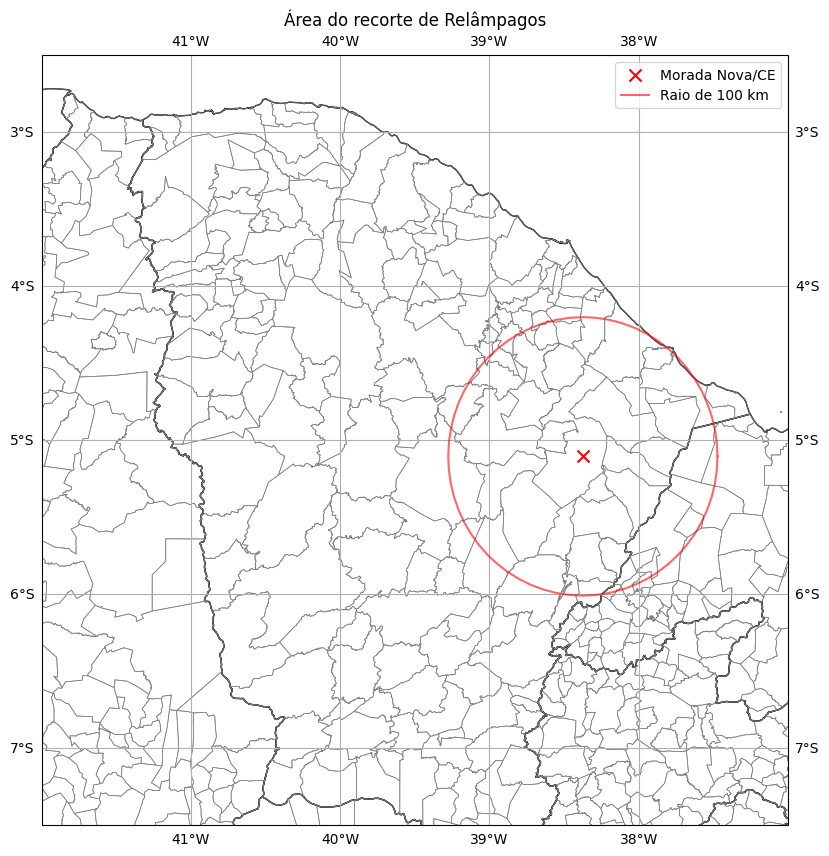

In [5]:
# Importando as bibliotecas necessárias
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import pyproj
import geopandas as gpd

# Função para gerar o círculo geodésico
def geodesic_point_buffer(lat, lon, km):
    # Projeção em coordenadas geográficas (WGS84)
    proj_wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')

    # Projeção azimutal equidistante para uma localização central
    azimuthal_proj = pyproj.Proj(proj='aeqd', datum='WGS84', lat_0=lat, lon_0=lon)

    # Funções de transformação
    project = pyproj.Transformer.from_proj(proj_wgs84, azimuthal_proj, always_xy=True).transform
    inv_project = pyproj.Transformer.from_proj(azimuthal_proj, proj_wgs84, always_xy=True).transform

    # Criando o círculo com buffer em metros
    point = Point(0, 0).buffer(km * 1000)  # Buffer em metros
    point_wgs84 = transform(inv_project, point).exterior.coords[:]

    return np.array(point_wgs84)

# Gerando os pontos do círculo
circle_points = geodesic_point_buffer(latitude, longitude, raio)

# Criando a projeção do mapa
proj = ccrs.PlateCarree()

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Adicionando as linhas de latitude e longitude
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# Adicionando as costas e bordasax.coastlines(resolution='110m')

# Plotando os estados e municípios
estados.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, label='Estado')  # Estados em preto
municipios.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=0.5, label='Municipios')  # Municípios em cinza

# Definindo os limites do mapa para o Ceará
ax.set_extent([-42, -37, -7.5, -2.5], crs=ccrs.PlateCarree())

# Adicionando um ponto no mapa
ax.scatter(longitude, latitude, color='red', marker='x', s=75, label='Morada Nova/CE')  # Adiciona um ponto

# Plotando o círculo usando os pontos calculados
ax.plot(circle_points[:, 0], circle_points[:, 1], color='red', alpha=0.6, label='Raio de 100 km')

# Título do gráfico
ax.set_title("Área do recorte de Relâmpagos")

# Exibindo a legenda
ax.legend()

# Exibindo o mapa
plt.show()


In [6]:
from shapely.geometry import Polygon

# Criando um polígono a partir dos pontos do círculo
polygon_geom = Polygon(circle_points)

# Criando um GeoDataFrame com o polígono
circle_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

# Salvando o GeoDataFrame como um arquivo shapefile
circle_gdf.to_file("circle_area.shp")

print("Arquivo shapefile 'circle_area.shp' criado com sucesso!")


Arquivo shapefile 'circle_area.shp' criado com sucesso!


# **Donwload GLM**
a
>a.

a:
1.   a
2.   a


Script desensolvido para o projeto de tese que visa analisar a metodologia de `lightningjump` no estado do ceará com dados de pluviometros da Funceme e dados de relâmpagos do GLM

Autor: Samuel Amorim Silva (2024)


In [7]:
import xarray as xr
from datetime import datetime
import pandas as pd
import os
import time
import warnings
import logging
warnings.filterwarnings("ignore")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Montar o Google Drive
drive.mount('/content/drive')

# Definindo o diretório
dir = '/content/drive/MyDrive/casostese/teste5/'

# Criar o diretório
os.makedirs(f'{dir}', exist_ok=True)

print(f'Diretório criado: {dir}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório criado: /content/drive/MyDrive/casostese/teste5/


In [11]:
def download_GLM5min_CPTEC(ano, mes, dia, hor, min, dir):
    print('.... Baixando dado ===>', 'DATA=', ano, mes, dia, hor, min)

    # caminho do ftp do cptec
    ftp_cptec_glm_5min = 'http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/'

    # código do produto
    codigo_produto = 'S11635949'

    # nome do arquivo
    nome_arquivo = f'{codigo_produto}_{ano}{mes}{dia}{hor}{min}.nc'
    file_glm5min_cptec = f'{ftp_cptec_glm_5min}{ano}/{mes}/{nome_arquivo}'

    # baixando a imagem de satélite
    os.system(f'wget -c {file_glm5min_cptec} -P {dir}')

    # local da imagem que foi baixada
    file_glm_download = os.path.join(dir, nome_arquivo)

    # Verifica se o arquivo foi baixado
    if os.path.isfile(file_glm_download):
        print(f'Arquivo baixado com sucesso: {file_glm_download}')
    else:
        print('Erro: O arquivo não foi baixado.')

    return file_glm_download
codigo_produto = 'S11635949'

In [12]:
#DEFINA
# ano, mes, dia, hora, minuto
anoi, mesi, diai, horai, mini = '2023', '02', '05', '16', '10'
anof, mesf, diaf, horaf, minf = '2023', '02', '06', '03', '00'


In [13]:
%%time
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define as datas inicial e final
start_date = datetime(int(anoi), int(mesi), int(diai), int(horai), int(mini))
start_str = start_date.strftime('%Y%m%d%H%M')

end_date = datetime(int(anof), int(mesf), int(diaf), int(horaf), int(minf))
end_str = end_date.strftime('%Y%m%d%H%M')

print('Iniciando o Processamento de Dados, aguarde...:', start_str, end_str, '\n')

# Lista para armazenar os arquivos de imagens
image_files = []
for current_time in pd.date_range(start_str, end_str, freq='5min'):
    current_str = current_time.strftime('%Y%m%d%H%M')
    year = current_time.strftime('%Y')
    month = current_time.strftime('%m')
    day = current_time.strftime('%d')
    hour = current_time.strftime('%H')
    minute = current_time.strftime('%M')

    logging.info(f"Baixando arquivo para: {current_str}")
    try:
        downloaded_file = download_GLM5min_CPTEC(year, month, day, hour, minute, dir)
        if downloaded_file and os.path.exists(downloaded_file):
            logging.info(f"Arquivo já existe: {downloaded_file}")
        else:
            image_files.append(downloaded_file)
    except Exception as e:
        logging.error(f"Erro ao baixar o arquivo para {current_str}: {e}")
        continue  # continua para a próxima iteração

logging.info(f"Processo concluído. Total de arquivos baixados: {len(image_files)}")

Iniciando o Processamento de Dados, aguarde...: 202302051610 202302060300 

.... Baixando dado ===> DATA= 2023 02 05 16 10
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051610.nc
.... Baixando dado ===> DATA= 2023 02 05 16 15
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051615.nc
.... Baixando dado ===> DATA= 2023 02 05 16 20
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051620.nc
.... Baixando dado ===> DATA= 2023 02 05 16 25
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051625.nc
.... Baixando dado ===> DATA= 2023 02 05 16 30
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051630.nc
.... Baixando dado ===> DATA= 2023 02 05 16 35
Arquivo baixado com sucesso: /content/drive/MyDrive/casostese/teste5/S11635949_202302051635.nc
.... Baixando dado ===> DATA= 2023 02 05 16 40
Arquivo baixado com suces

In [14]:
import glob
import os

# Lista de arquivos .nc no diretório
files = glob.glob(os.path.join(dir, "*.nc"))

# Imprimir a lista de arquivos
print("Arquivos .nc encontrados no diretorio:")
for file in files:
    print(file)


Arquivos .nc encontrados no diretorio:
/content/drive/MyDrive/casostese/teste5/S11635949_202302051610.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051615.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051620.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051625.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051630.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051635.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051640.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051645.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051650.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051655.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051700.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051705.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051710.nc
/content/drive/MyDrive/casostese/teste5/S11635949_202302051715.nc
/content/drive/MyDrive/casostese/test

In [15]:
# Criação das strings de data e hora
start_time = f'{anoi}-{mesi}-{diai} {horai}:{mini}:00'  # 2023-02-05 12:00:00
end_time = f'{anof}-{mesf}-{diaf} {horaf}:{minf}:00'    # 2023-02-06 05:00:00

# Criação de uma nova coordenada de tempo com intervalo de 5 minutos
new_time_coords = pd.date_range(start=start_time, end=end_time, freq='5T')

# Leitura dos dados
glm_5min = xr.open_mfdataset(files,
                             concat_dim='time',
                             combine='nested',
                             decode_times=False).sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))

# Adicionando a nova coordenada de tempo ao dataset
glm_5min = glm_5min.assign_coords(time=('time', new_time_coords))

# Verifique a estrutura do dataset atualizado
print(glm_5min)


<xarray.Dataset> Size: 2MB
Dimensions:         (time: 131, lat: 23, lon: 23)
Coordinates:
  * lat             (lat) float32 92B -6.0 -5.92 -5.84 ... -4.4 -4.32 -4.24
  * lon             (lon) float32 92B -39.24 -39.16 -39.08 ... -37.56 -37.48
  * time            (time) datetime64[ns] 1kB 2023-02-05T16:10:00 ... 2023-02...
Data variables:
    spatial_ref     (time) int32 524B -2147483647 -2147483647 ... -2147483647
    event           (time, lat, lon) float32 277kB dask.array<chunksize=(1, 23, 23), meta=np.ndarray>
    flash           (time, lat, lon) float32 277kB dask.array<chunksize=(1, 23, 23), meta=np.ndarray>
    group           (time, lat, lon) float32 277kB dask.array<chunksize=(1, 23, 23), meta=np.ndarray>
    event_energy    (time, lat, lon) float32 277kB dask.array<chunksize=(1, 23, 23), meta=np.ndarray>
    flash_energy    (time, lat, lon) float32 277kB dask.array<chunksize=(1, 23, 23), meta=np.ndarray>
    group_energy    (time, lat, lon) float32 277kB dask.array<chunksize=

In [16]:
# Instalando salem
!pip install -q salem==0.3.9
# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.8 MB/s eta 0:00:00


In [17]:
import salem
import rasterio

In [18]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
shp = salem.read_shapefile(f'{url}cinco_regioes_brasil/regioes_2010.shp')

# Soma os dados de relâmpagos ao longo do tempo
flash = glm_5min['flash'].sum(dim='time')

# Verifique o formato do DataArray flash
print(f"Formato de flash: {flash.shape}")

# Imprima os valores mínimo e máximo de longitude e latitude do dado
print(f"Longitude mínima: {flash['lon'].min().values}, Longitude máxima: {flash['lon'].max().values}")
print(f"Latitude mínima: {flash['lat'].min().values}, Latitude máxima: {flash['lat'].max().values}")

# Verifique se os limites de longitude e latitude para o extent estão dentro dos limites do dado
print(f"lonmin: {lonmin}, lonmax: {lonmax}, latmin: {latmin}, latmax: {latmax}")

# Seleciona a área do Brasil usando a máscara do shapefile
flash = flash.salem.roi(shape=shp)

# Exibe a soma total de relâmpagos na área selecionada
print(f"Soma total de relâmpagos na área selecionada: {flash.sum().values}")


Formato de flash: (23, 23)
Longitude mínima: -39.23999786376953, Longitude máxima: -37.47999572753906
Latitude mínima: -5.999997615814209, Latitude máxima: -4.239997386932373
lonmin: -39.27660455605617, lonmax: -37.47079544394383, latmin: -6.005321605918731, latmax: -4.206678394081269
Soma total de relâmpagos na área selecionada: 3220.0


In [19]:
# Soma os dados de relâmpagos ao longo do tempo
flash_h = glm_5min['flash']

# Filtrar os dados dentro da extensão
flash_h_subset = flash_h.where(
    (flash_h['lat'] >= latmin) & (flash_h['lat'] <= latmax) &
    (flash_h['lon'] >= lonmin) & (flash_h['lon'] <= lonmax),
    drop=True
)

# Extrair as datas
datas = flash_h_subset['time'].values

# Contar o número de flashes em cada ponto de tempo
quantidade_flashes = flash_h_subset.sum(dim=('lat', 'lon')).values

# Verificando o resultado
print(f"Datas: {datas}")
print(f"Quantidade de flashes: {quantidade_flashes}")


Datas: ['2023-02-05T16:10:00.000000000' '2023-02-05T16:15:00.000000000'
 '2023-02-05T16:20:00.000000000' '2023-02-05T16:25:00.000000000'
 '2023-02-05T16:30:00.000000000' '2023-02-05T16:35:00.000000000'
 '2023-02-05T16:40:00.000000000' '2023-02-05T16:45:00.000000000'
 '2023-02-05T16:50:00.000000000' '2023-02-05T16:55:00.000000000'
 '2023-02-05T17:00:00.000000000' '2023-02-05T17:05:00.000000000'
 '2023-02-05T17:10:00.000000000' '2023-02-05T17:15:00.000000000'
 '2023-02-05T17:20:00.000000000' '2023-02-05T17:25:00.000000000'
 '2023-02-05T17:30:00.000000000' '2023-02-05T17:35:00.000000000'
 '2023-02-05T17:40:00.000000000' '2023-02-05T17:45:00.000000000'
 '2023-02-05T17:50:00.000000000' '2023-02-05T17:55:00.000000000'
 '2023-02-05T18:00:00.000000000' '2023-02-05T18:05:00.000000000'
 '2023-02-05T18:10:00.000000000' '2023-02-05T18:15:00.000000000'
 '2023-02-05T18:20:00.000000000' '2023-02-05T18:25:00.000000000'
 '2023-02-05T18:30:00.000000000' '2023-02-05T18:35:00.000000000'
 '2023-02-05T18:40

In [20]:
flash_h_subset

<xarray.DataArray 'flash' (time: 131, lat: 23, lon: 23)> Size: 277kB
dask.array<where, shape=(131, 23, 23), dtype=float32, chunksize=(1, 23, 23), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 92B -6.0 -5.92 -5.84 -5.76 ... -4.48 -4.4 -4.32 -4.24
  * lon      (lon) float32 92B -39.24 -39.16 -39.08 ... -37.64 -37.56 -37.48
  * time     (time) datetime64[ns] 1kB 2023-02-05T16:10:00 ... 2023-02-06T03:...
Attributes:
    units:                                                  flash/5minutes/64km2
    standard_name:                                          GLM Flash Centroi...
    valid_range:                                            [    0. 10000.]
    lat_field_of_view:                                      [ 66.56 -66.56]
    lon_field_of_view:                                      [ 66.56 -66.56]
    keywords:                                               lightning/goes/gl...
    FillValue:                                              0
    goes_imager_projection_longitude_of_projection_origin:  -89.5

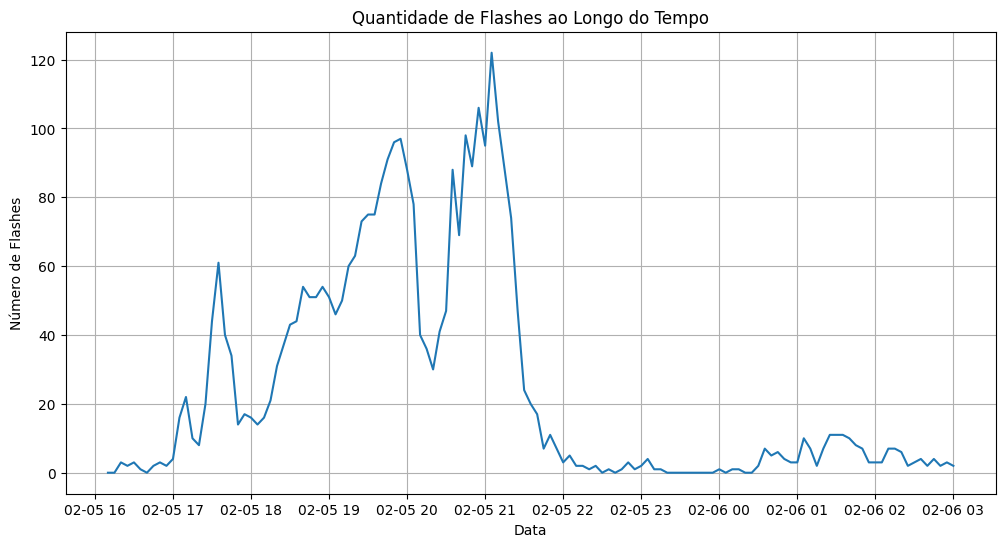

In [21]:
# prompt: plotar flash_h_subset

import matplotlib.pyplot as plt

# Plotar a série temporal de flashes
plt.figure(figsize=(12, 6))
plt.plot(flash_h_subset['time'].values, flash_h_subset.sum(dim=('lat', 'lon')).values)
plt.xlabel('Data')
plt.ylabel('Número de Flashes')
plt.title('Quantidade de Flashes ao Longo do Tempo')
plt.grid(True)
plt.show()


In [35]:
import xarray as xr
import pandas as pd
import numpy as np

# Defina os parâmetros de entrada
# Variáveis de entrada baseadas no que você forneceu
# Suponha que 'glm_5min' já foi carregado e contém os dados necessários

# Passo 1: Calcular a taxa de relâmpagos média (FRavg) em intervalos de tempo de 5 minutos
# Aqui estamos assumindo que o dataset já tem uma variável chamada 'flash_count'
# que representa a contagem total de relâmpagos em cada intervalo.

# Cálculo da taxa média de relâmpagos
# flash_count = flash_h_subset.sum(dim=('lat', 'lon')).values # Original line causing error
# Convertendo flash_h_subset para um DataArray xarray ao longo da dimensão 'time'
flash_count = flash_h_subset.sum(dim=('lat', 'lon')).to_series()

# Convertendo flash_count para um pandas Series para usar .rolling()
flash_count = pd.Series(flash_count)

FRavg = flash_count.rolling(2).mean()  # Média sobre 2 intervalos de 5 minutos

# Passo 2: Calcular a DFRDT (Derivada da Taxa de Relâmpagos)
# A mudança em relação ao tempo deve ser expressa em minutos
DFRDT = FRavg.diff() / (5 / 60)  # Diferença em relação ao tempo em minutos

# Passo 3: Definir critérios para identificar um *lightning jump*
# Por exemplo, considere um *jump* se DFRDT > 2 * desvio padrão da DFRDT
threshold = 2 * DFRDT.std()  # Definindo um threshold como 2 desvios padrão

# Identificando onde os jumps ocorrem
lightning_jumps = DFRDT > threshold

# Passo 4: Visualizar ou salvar os resultados
# Por exemplo, podemos salvar os índices de tempo onde os *jumps* ocorrem

# Convertendo lightning_jumps para um DataArray com as mesmas coordenadas de tempo que glm_5min
lightning_jumps_xr = xr.DataArray(lightning_jumps.values, coords=[flash_h_subset['time']], dims=['time'])

# Usando o DataArray lightning_jumps_xr na função where
jump_times = flash_h_subset['time'].where(lightning_jumps_xr, drop=True)

# Exibindo os tempos de *lightning jumps*
print("Lightning Jump Times:")
print(jump_times)

Lightning Jump Times:
<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2023-02-05T17:30:00.000000000', '2023-02-05T17:35:00.000000000',
       '2023-02-05T20:35:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2023-02-05T17:30:00 ... 2023-02-05T20:...


In [27]:
jump_times

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2023-02-05T17:30:00.000000000', '2023-02-05T17:35:00.000000000',
       '2023-02-05T20:35:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2023-02-05T17:30:00 ... 2023-02-05T20:...

In [28]:
flash_count

,flash
time,
2023-02-05 16:10:00,0.0
2023-02-05 16:15:00,0.0
2023-02-05 16:20:00,3.0
2023-02-05 16:25:00,2.0
2023-02-05 16:30:00,3.0
...,...
2023-02-06 02:40:00,2.0
2023-02-06 02:45:00,4.0
2023-02-06 02:50:00,2.0


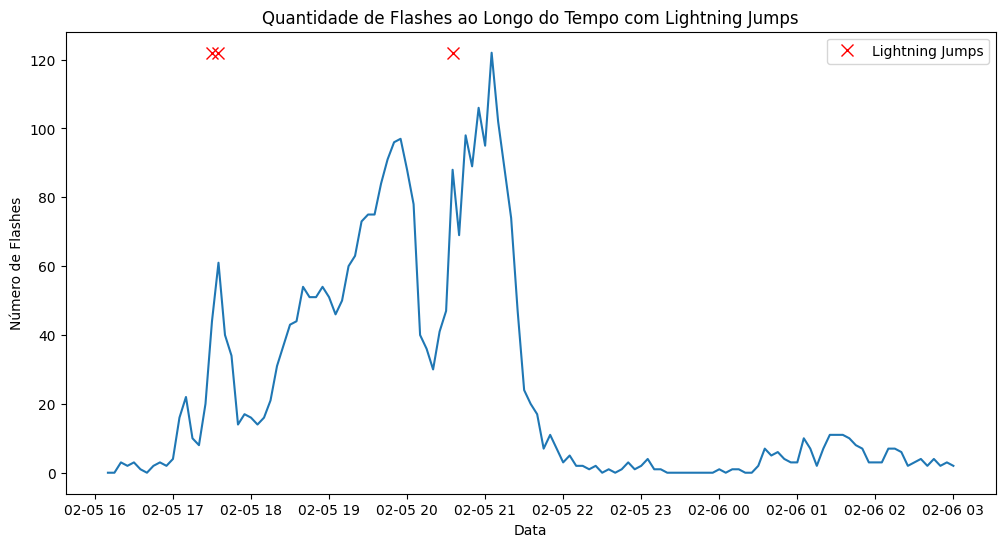

In [38]:
# prompt: plotar neste gráfico com um x os quando o tempo for o mesmo de jump_times

# Plotar a série temporal de flashes com 'x' nos tempos de jump
plt.figure(figsize=(12, 6))
plt.plot(flash_h_subset['time'].values, flash_h_subset.sum(dim=('lat', 'lon')).values)
plt.xlabel('Data')
plt.ylabel('Número de Flashes')
plt.title('Quantidade de Flashes ao Longo do Tempo com Lightning Jumps')
plt.grid(False)

# Marcar os tempos de jump com 'x' no gráfico
plt.plot(jump_times.values, np.full(len(jump_times), flash_h_subset.sum(dim=('lat', 'lon')).max()), 'x', color='red', markersize=8, label='Lightning Jumps')

plt.legend()
plt.show()